## Recurrent Neural Network with LSTM

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 0.3012
Epoch 2/50
5/5 [==============================] - 0s 30ms/step - loss: 0.1992
Epoch 3/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0965
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0236
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0209
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0231
Epoch 7/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0084
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0110
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0085
Epoch 11/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0069
Epoch 12/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0066
Epoch 13/50
5/5 [==============================] - 0s 34ms/st

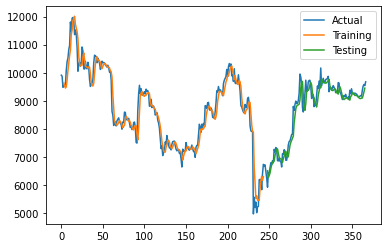

In [5]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from pandas import Series
import math

data = pd.read_csv('BTC-USD.csv')
data = data.set_index(pd.DatetimeIndex(data['Date']))['Close']

def difference(dataset, interval = 1):
    diffList = list()
    for i in range(interval, len(dataset)):
        num = dataset[i] - dataset[i - interval]
        diffList.append(num)
    return Series(diffList)

backView = 3
    
def create_dataset(dataset, backView = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - backView - 1):
        a = dataset[i:(i + backView), 0]
        dataX.append(a)
        dataY.append(dataset[i + backView, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(0)

# loading dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalizing dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]

# reshape into Y = t + 1 and X = t
trainX, trainY = create_dataset(train, backView)
testX, testY = create_dataset(test, backView)

# reshape input to [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()

model.add(LSTM(256, return_sequences = True, input_shape = (1, backView)))
model.add(LSTM(256))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = 50, verbose = 1, shuffle = False, batch_size = 50)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[backView:len(trainPredict) + backView, :] = trainPredict
predictions[len(trainPredict) + (backView * 2) + 1:len(dataset) - 1, :] = testPredict

predictionsDF = pd.DataFrame(predictions,columns = ["predicted"],index = dataframe.index)
ans = pd.concat([dataframe,predictionsDF],axis = 1)
print(ans, [backView, trainScore,testScore])

#   shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[backView:len(trainPredict) + backView, :] = trainPredict

#   shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict) + (backView * 2) + 1:len(dataset) - 1, :] = testPredict
    
#   plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = 'Actual')
plt.plot(trainPredictPlot, label = 'Training')
plt.plot(testPredictPlot, label = 'Testing')
plt.legend()
plt.show()

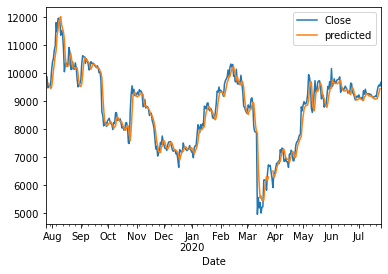

In [3]:
ans.plot()